This test should display first few rows of dataframe with time of day & Temperature (F) column:
             Timestamp Building_ID  Energy_Usage (kWh)  Temperature (C)  \
0  2025-01-01 00:00:00        B001              121.30            -7.20   
1  2025-01-01 01:00:00        B001              230.76            12.62   
2  2025-01-01 02:00:00        B001              187.21            -1.33   
3  2025-01-01 03:00:00        B001              262.23             0.24   
4  2025-01-01 04:00:00        B001              472.97             5.44   

   Humidity (%) Building_Type Occupancy_Level TimeOfDay  Temperature (F)  
0         79.36    Industrial             Low     night           19.040  
1         80.37    Industrial            High     night           54.716  
2         37.74    Industrial            High     night           29.606  
3         39.97    Industrial            High     night           32.432  
4         89.29    Industrial          Medium     night           41.792  
Thi

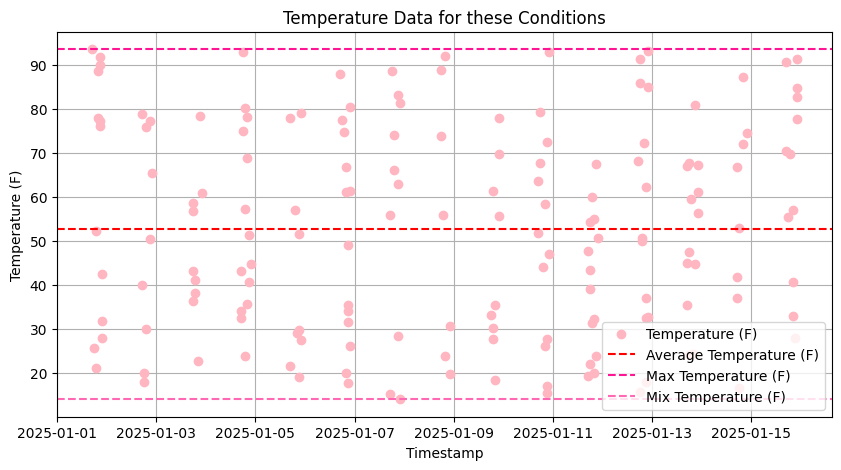

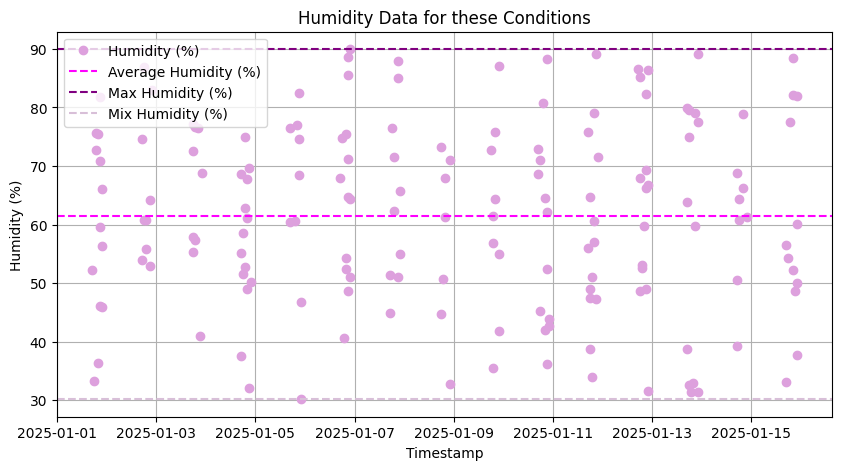

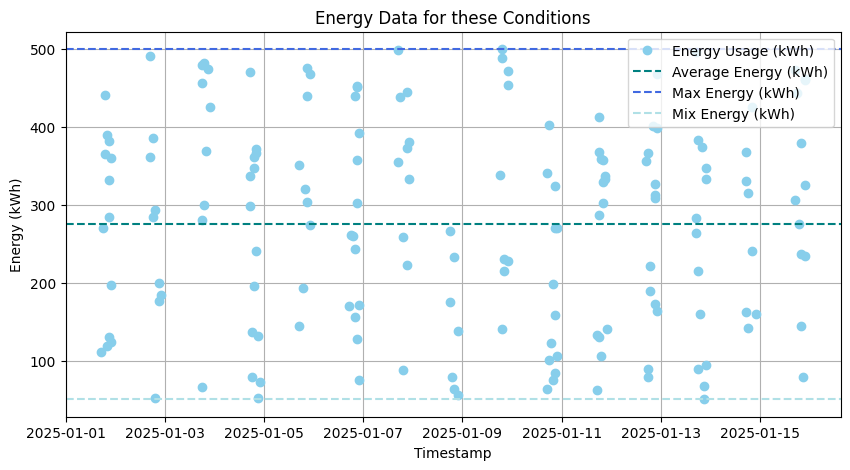

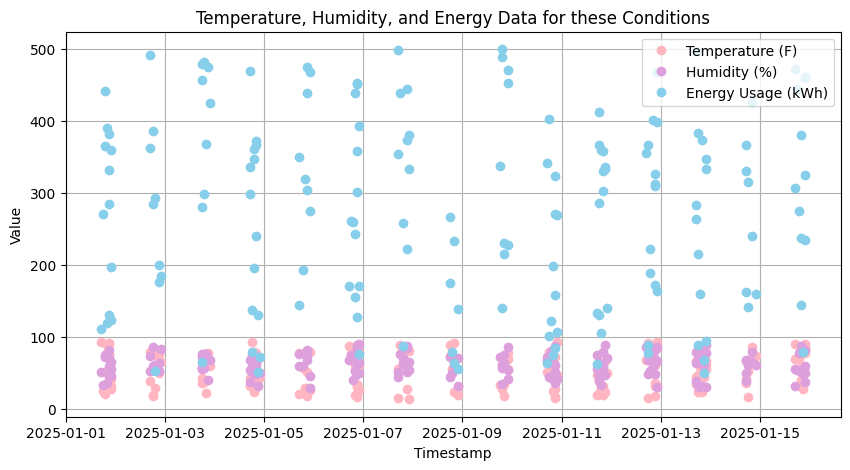

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class Building:
    def __init__(self, dataframe):
        # sets up the full dataset rather than just the selected one
        #PANDAS Dataframe is mutable
        self.df = dataframe.copy()

        # storing lists of all the data - looks at columns and pulls them as attributes
        self.timestamps = self.df["Timestamp"]
        self.energy = pd.to_numeric(self.df["Energy_Usage (kWh)"], errors="coerce")
        self.temperature = pd.to_numeric(self.df["Temperature (C)"], errors="coerce")
        self.humidity = pd.to_numeric(self.df["Humidity (%)"], errors="coerce")
        self.occupancy = self.df["Occupancy_Level"]
        self.building_type = self.df["Building_Type"]
        
    def __len__(self): #operator overloading for len() function
        return len(self.df)

    def __str__(self): # returns a readable string summarizing dataset for checking, #len() is also a built in module/library
        return (
            f"Total records: {len(self)}\n"
            f"Average Energy Usage: {self.energy.mean():.2f}\n"
            f"Average Temperature: {self.temperature.mean():.2f}\n"
            f"Average Humidity: {self.humidity.mean():.2f}"
        )

    

# Load data
df = pd.read_csv("building_energy_data_extended.csv")

#The dictionary of buildings is an mutable object
buildings = {"ALL": Building(df)}

class BuildingCalc:
    """
    This class has a composition relationship with the Building class. 
    Ex. Week 12 Composition Slides: "has-a" relationship
    Class function is to calculate estimates for energy, temp, humidity based
    on inputs of: building type, occupancy level, and time
    """
    def __init__(self, building):
        #this is a constructor.
        #Storing the building instance in this separate class.
        self.building = building #composition within this class to the previous class
        # dataframe from the building instance.
        df = self.building.df.copy()
        #Filtering the data to create a new timeofday column (separates timestamps)
        df["TimeOfDay"] = df["Timestamp"].apply(self._categorize_time)
        # getting the data in Fahrenheit rather than Celcius 
        df["Temperature (F)"] = [temp * 9/5 + 32 for temp in df["Temperature (C)"]] # list comprehension
        self.df = df
        

    def _categorize_time(self, ts):
        #This function works by sorting the timestamps into morning, afternoon, evening, night
        hour = pd.to_datetime(ts).hour

        if 6 <= hour < 12:
            return "morning"
        elif 12 <= hour < 17:
            return "afternoon"
        elif 17 <= hour < 23:
            return "evening"
        else:
            return "night"
        
    #Determines the avg energy, temp, humidity given the:
    #Building type, occupancy level, and time period
    def estimate(self, building_type, occupancy_level, time_period, show_rows = False):
        #Process details:
        #Select all rows which fulfill the filter requirements
        # Use filter + lambda to select matching rows
        # Source: Week 14 – Built-in functions (filter, lambda)
        filtered = pd.DataFrame(
            #Filter is an example of a built in module/functionality
            filter(
                lambda row: 
                (row["Building_Type"] == building_type and row["Occupancy_Level"] == occupancy_level and row["TimeOfDay"] == time_period), self.df.to_dict("records"))
        )

        #State there is no data for this case, if there is no match- using valueerror
        if filtered.empty:
            raise ValueError("No data available for the given parameters.")
        

        #This if statement is for testing to ensure the correct data rows are used for testing
        #if show_rows:
        #    print("Filtered DataFrame used for calculation:")
        #    print(filtered)
        #    print()

        #Calc the average of filtered datasets
        return {
            "Estimated Temperature (C)": filtered["Temperature (C)"].mean(),

            "Estimated Temperature (F)": filtered["Temperature (F)"].mean(),
            "Temperature Minimum (F)": filtered["Temperature (F)"].min(),
            "Temperature Maximum (F)": filtered["Temperature (F)"].max(),

            "Estimated Humidity (%)": filtered["Humidity (%)"].mean(),
            "Humidity Minimum (%)": filtered["Humidity (%)"].min(),
            "Humidity Maximum (%)": filtered["Humidity (%)"].max(),

            "Estimated Energy (kWh)": filtered["Energy_Usage (kWh)"].mean(),
            "Energy Minimum (kWh)": filtered["Energy_Usage (kWh)"].min(),
            "Energy Maximum (kWh)": filtered["Energy_Usage (kWh)"].max()
        } 
    def row_check(self, building_type, occupancy_level, time_period):
        #Generator function to show rows matching criteria input by user
        for row in self.df.to_dict("records"):
            if (
                row["Building_Type"] == building_type and 
                row["Occupancy_Level"] == occupancy_level and 
                row["TimeOfDay"] == time_period
            ):
                yield row


#Commented. Was used to test and ensure specific buildings were imported correctly.
# For loop to group dataset by Building_ID
#for building_id, group in df.groupby("Building_ID"):
#    building_type = group["Building_Type"].iloc[0]

#    b = Building(building_id, building_type)
#    b.recording_data(group)

#    buildings[building_id] = b



if __name__ == "__main__": # protects the main running function

    
    # while loop to let user choose what building stats they wanna see
    while True:
        user_input = input("Enter 'ALL' to see dataset stats ('X' to exit): ").strip()
        if user_input.lower() == 'x':
            break
        elif user_input in buildings:
            print(buildings[user_input])
        else:
            try:
                raise ValueError(f"Invalid Building ID entered: '{user_input}'")
            except ValueError as e:
                print("Error:", e)


    #TESTING SECTION:
    #Test for the __str__
    test_building = buildings["ALL"]
    #print("This test should display building statistics All Buildings:")
    #print(test_building)

    #Test for building calc class
    calc = BuildingCalc(test_building)
    print("This test should display first few rows of dataframe with time of day & Temperature (F) column:")
    print(calc.df.head())

    #Test estimate avg functionality:
    print("This should pring the avg energy, temp, humidity for given param")
    result = calc.estimate(building_type="Industrial", occupancy_level="High", time_period="afternoon", show_rows = True)
    print(result)

    # updated to work with the new building & buildingcalc classes
    print()
    while True:
        try:
            # this asks the user to enter the building type, occupancy level, and time of day they want to see the avg energy for... 
            
            # for reference: 
            #(row["Building_Type"] == building_type and row["Occupancy_Level"] == occupancy_level and row["TimeOfDay"] == time_period)
            
            # allow user to enter building type or number corresponding (streamlined)
            user_build = input("Enter a building type (1 - Industrial, 2 - Commercial, 3 - Residential, 4 - Educational) ('X or x' to exit):").strip()
            if user_build == 'X' or user_build == 'x': # check if want exit/cancel
                break
            valid_builds = ["1", "2", "3", "4", "Industrial", "Commercial", "Residential", "Educational"] 
            # accepts both numbers and words so user can do whichever they want

            if user_build not in valid_builds: # raise an error if user's input is invalid
                raise ValueError("Invalid building entered.")
            
            # sets the numbers back to the word values 
            if user_build == "1": user_build = "Industrial"
            elif user_build == "2": user_build = "Commercial"
            elif user_build == "3": user_build = "Residential"
            elif user_build == "4": user_build = "Educational"


            # allow user to enter occupancy levels (repeat steps above)
            user_occ = input("Enter an occupancy level (1 - High, 2 - Medium, 3 - Low) ('X or x' to exit):").strip()
            if user_occ == 'X' or user_occ == 'x':
                break
            valid_occs = ["1", "2", "3", "High", "Medium", "Low"]
            if user_occ not in valid_occs:
                raise ValueError("Invalid level entered.")
            
            if user_occ == "1": user_occ = "High"
            elif user_occ == "2": user_occ = "Medium"
            elif user_occ == "3": user_occ = "Low"
            

            # allow user to enter time of day (repeat steps above)
            user_time = input("Enter a time of day (1 - morning, 2 - afternoon, 3 - evening, 4 - night) ('X or x' to exit):").strip()
            if user_time == 'X' or user_time == 'x':
                break
            #VALID_TIMES is a constant tuple- which is immutable
            VALID_TIMEOFDAY = ("morning", "afternoon", "evening", "night")
            valid_times = ("1", "2", "3", "4") + VALID_TIMEOFDAY
            if user_time not in valid_times:
                raise ValueError("Invalid time of day entered.")
            
            if user_time == "1": user_time = "morning"
            elif user_time == "2": user_time = "afternoon"
            elif user_time == "3": user_time = "evening"
            elif user_time == "4": user_time = "night"


            # the average calculations for all of the user specified conditions
            avg_calculations = calc.estimate(building_type = user_build, occupancy_level = user_occ, time_period = user_time)
            
            # get the estimated energy/temp/humidity value from returned dict value
            avg_temperature_value = avg_calculations['Estimated Temperature (F)']
            avg_humidity_value = avg_calculations['Estimated Humidity (%)']
            avg_energy_value = avg_calculations['Estimated Energy (kWh)'] 

            # show range of values for the users values
            # lower limit
            min_temperature_value = avg_calculations['Temperature Minimum (F)']
            min_humidity_value = avg_calculations['Humidity Minimum (%)']
            min_energy_value = avg_calculations['Energy Minimum (kWh)']

            # upper limit
            max_temperature_value = avg_calculations['Temperature Maximum (F)']
            max_humidity_value = avg_calculations['Humidity Maximum (%)']
            max_energy_value = avg_calculations['Energy Maximum (kWh)']

            # clean lines for the user to read what is going on:
            print(f"The following results are displayed for a {user_build} building with {user_occ} people in the {user_time}:")
            
            # temp displays
            print(f"The temperature values fall in a range from {min_temperature_value:.2f}°F to {max_temperature_value:.2f}°F")
            print(f"The average temperature (F) is {avg_temperature_value:.2f}°F")
            
            # humidity displays
            print(f"The humidity values fall in a range from {min_humidity_value:.2f}% to {max_humidity_value:.2f}%")
            print(f"The average humidity (%) is {avg_humidity_value:.2f}%")
            
            # energy displays
            print(f"The energy values fall in a range from {min_energy_value:.2f} kWh to {max_energy_value:.2f} kWh")
            print(f"The average energy consumption (kWh) is {avg_energy_value:.2f} kWh")
            

            #print from generator function the rows matching criteria
            print("\nRows matching selected criteria:\n")


            # empty shells for the data to store data from calc.row_check
            timestamps = []
            temperature = []
            humidity = []
            energy = []
            avgTemp = []

            # looping through filtered rows 
            for row in calc.row_check(
                building_type=user_build,
                occupancy_level=user_occ,
                time_period=user_time
                ):
                print(row) # shows the row for verification

                # appending each data point to its list
                timestamps.append(row['Timestamp'])
                temperature.append(row['Temperature (F)'])
                humidity.append(row['Humidity (%)'])
                energy.append(row['Energy_Usage (kWh)'])

            # creating the DataFrame from lists
            df = pd.DataFrame({
                'Timestamp': timestamps,
                'Temperature': temperature,
                'Humidity': humidity,
                'Energy': energy,
                
            })
            

            # converting the timestamp to datetime for sorting in order of time
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])
            df.sort_values('Timestamp', inplace = True) # sort the values

            # plotting temperature only
            plt.figure(figsize = (10, 5))
            plt.plot(df['Timestamp'], df['Temperature'], marker = 'o', color = 'lightpink', linestyle = 'None', label = 'Temperature (F)')
            # plotting a horizontal line at the mean/max/min temperature with axhline
            plt.axhline(df['Temperature'].mean(), color = 'red', linestyle = '--', label = 'Average Temperature (F)')
            plt.axhline(df['Temperature'].max(), color = 'deeppink', linestyle = '--', label = 'Max Temperature (F)')
            plt.axhline(df['Temperature'].min(), color = 'hotpink', linestyle = '--', label = 'Mix Temperature (F)')

            plt.title("Temperature Data for these Conditions")
            plt.xlabel("Timestamp")
            plt.ylabel("Temperature (F)")
            plt.legend()
            plt.grid(True)
            plt.show()


            # plotting humidity only
            plt.figure(figsize = (10, 5))
            plt.plot(df['Timestamp'], df['Humidity'], marker = 'o', color = 'plum', linestyle = 'None', label = 'Humidity (%)')
            # plotting a horizontal line at the mean/max/min temperature with axhline
            plt.axhline(df['Humidity'].mean(), color = 'magenta', linestyle = '--', label = 'Average Humidity (%)')
            plt.axhline(df['Humidity'].max(), color = 'purple', linestyle = '--', label = 'Max Humidity (%)')
            plt.axhline(df['Humidity'].min(), color = 'thistle', linestyle = '--', label = 'Mix Humidity (%)')

            plt.title("Humidity Data for these Conditions")
            plt.xlabel("Timestamp")
            plt.ylabel("Humidity (%)")
            plt.legend()
            plt.grid(True)
            plt.show()


            # plotting energy only 
            plt.figure(figsize = (10, 5))
            plt.plot(df['Timestamp'], df['Energy'], marker = 'o', color = 'skyblue', linestyle = 'None', label = 'Energy Usage (kWh)')
            # plotting a horizontal line at the mean/max/min temperature with axhline
            plt.axhline(df['Energy'].mean(), color = 'teal', linestyle = '--', label = 'Average Energy (kWh)')
            plt.axhline(df['Energy'].max(), color = 'royalblue', linestyle = '--', label = 'Max Energy (kWh)')
            plt.axhline(df['Energy'].min(), color = 'powderblue', linestyle = '--', label = 'Mix Energy (kWh)')

            plt.title("Energy Data for these Conditions")
            plt.xlabel("Timestamp")
            plt.ylabel("Energy (kWh)")
            plt.legend()
            plt.grid(True)
            plt.show()
            

            # ploting all variables
            plt.figure(figsize = (10, 5))
            plt.plot(df['Timestamp'], df['Temperature'], marker = 'o', color = 'lightpink', linestyle = 'None', label = 'Temperature (F)')
            plt.plot(df['Timestamp'], df['Humidity'], marker = 'o', color = 'plum', linestyle = 'None', label = 'Humidity (%)')
            plt.plot(df['Timestamp'], df['Energy'], marker = 'o', color = 'skyblue', linestyle = 'None', label = 'Energy Usage (kWh)')

            plt.title("Temperature, Humidity, and Energy Data for these Conditions")
            plt.xlabel("Timestamp")
            plt.ylabel("Value")
            plt.legend()
            plt.grid(True)
            plt.show()


        except ValueError as e:
            print("Error:", e) # something happened